# CONSTANTES

In [1082]:
SEED = 42
HMAP_COLOR = "Oranges"

# TRABAJO PREDICCION VINOS
El objetivo de este fichero es mostrar los pasos realizados en la transformación y prueba con los modelos KNN y KNNRegressor del dataset del vino portugués

## Carga de librerias

In [1083]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,KBinsDiscretizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from scipy.signal import find_peaks

# FUNCIONES

In [1084]:
def fix_outliers(serie,column,strategy="median",k_value=1.5):
    Q1 = np.quantile(serie,0.25) # primer cuantil
    Q3 = np.quantile(serie,0.75) # tercer cuantil
    IQR = Q3 - Q1

    xl = Q1 - k_value*IQR # banda izquierda
    xu = Q3 + k_value*IQR # banda derecha

    strategy = np.median(serie)
    if(strategy=="mean"):
        strategy = np.mean(serie)

    for i in range(0,len(serie)):
        if(serie[i]<xl or serie[i]>xu):
            print(f"Outlier en el campo {column} posicion {i} con valor {serie[i]}")
            serie[i] = strategy
    return serie

## Carga de datos

In [1085]:
wine = pd.read_csv("./data/winequality-red.csv")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Informacion de los datos
Con este apartado comprobamos el tipo de las características y determinamos si hay valores nulos o no

In [1086]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Observamos que las caracteristicas son numéricas

## Visualización de los datos
En este apartado visualizamos los datos numéricos en un histograma visualizando su distribución

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

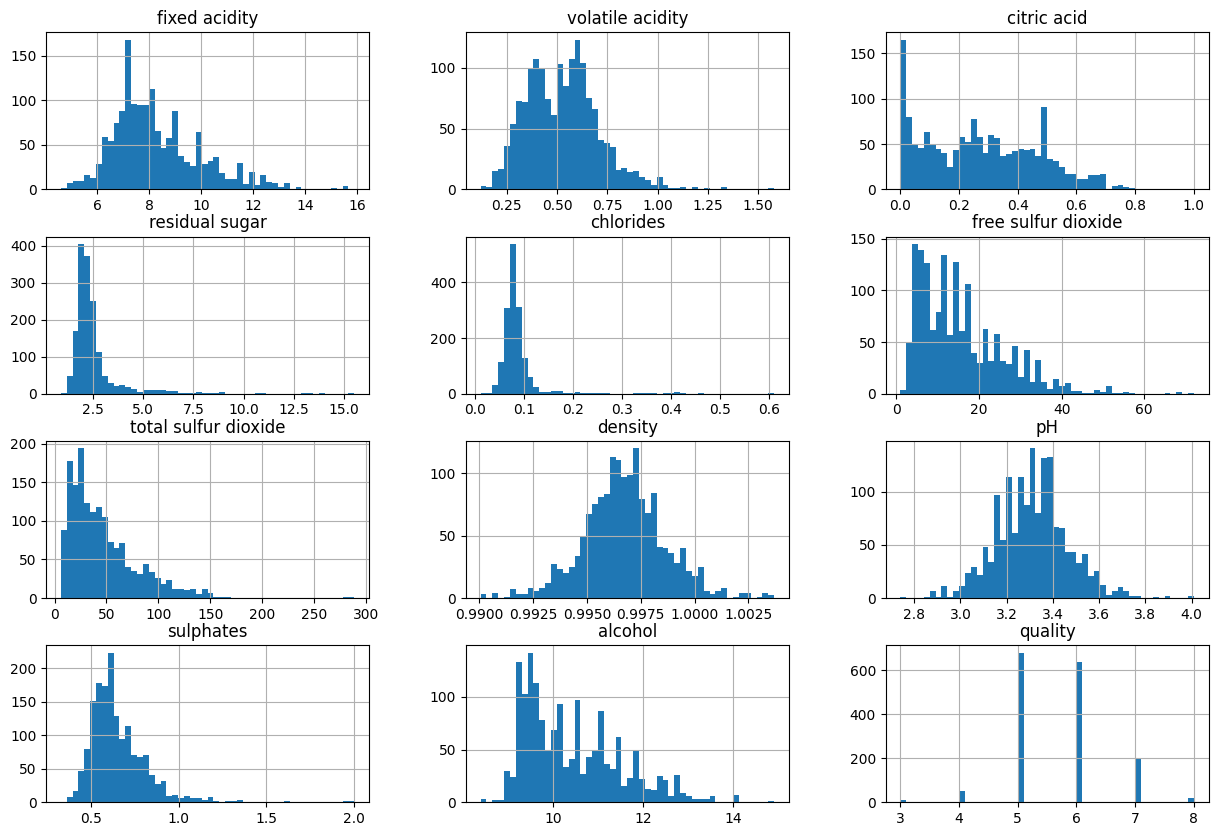

In [1087]:
wine.hist(bins=50,figsize=(15,10))

Observamos que las caracteristicas que presentan una distribución normal son:
- density
- sulphates
- pH
- fixed acidity

Las demás distribuciones presentan colas como total sulfur dioxide, residual sugar, alcohol y hay una multimodal que en este caso es volatile acidity que se tratarán una vez que separemos el conjunto en entrenamiento y test para que nuestro modelo no sobreaprenda

Además observamos que el objetivo quality presenta un desbalanceo importante, se balanceará una vez separemos el conjunto de datos

## Outliers
Hay que tratar los outliers de las distribuciones normales, para ello se cambiará el valor del outlier por la mediana

Como método se usará el rango intercuantil para detectar los outliers

Distribucion antes de tratar outliers


array([[<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'fixed acidity'}>]], dtype=object)

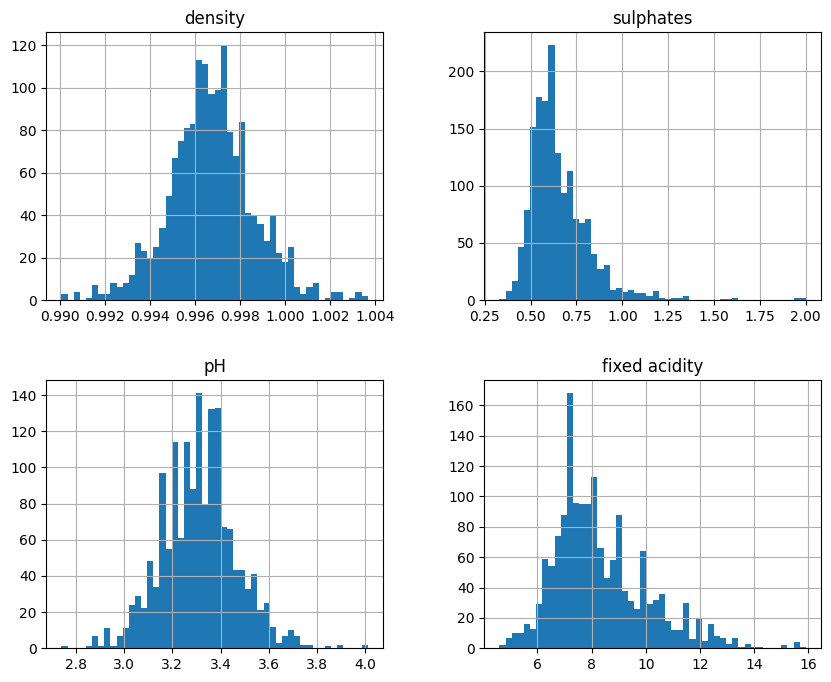

In [1088]:
df_normal = wine.get(["density","sulphates","pH","fixed acidity"])

print("Distribucion antes de tratar outliers")
df_normal.hist(bins=50,figsize=(10,8))

Outlier en el campo sulphates posicion 13 con valor 1.56
Outlier en el campo sulphates posicion 17 con valor 1.28
Outlier en el campo sulphates posicion 81 con valor 1.28
Outlier en el campo sulphates posicion 86 con valor 1.95
Outlier en el campo sulphates posicion 91 con valor 1.95
Outlier en el campo sulphates posicion 92 con valor 1.98
Outlier en el campo sulphates posicion 106 con valor 1.31
Outlier en el campo sulphates posicion 151 con valor 2.0
Outlier en el campo sulphates posicion 169 con valor 1.59
Outlier en el campo sulphates posicion 226 con valor 1.61
Outlier en el campo sulphates posicion 339 con valor 1.36
Outlier en el campo sulphates posicion 614 con valor 1.36
Outlier en el campo sulphates posicion 639 con valor 1.36
Outlier en el campo sulphates posicion 723 con valor 1.62
Outlier en el campo sulphates posicion 1051 con valor 1.34
Outlier en el campo sulphates posicion 1319 con valor 1.33
Outlier en el campo pH posicion 1316 con valor 4.01
Outlier en el campo pH po

array([[<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'fixed acidity'}>]], dtype=object)

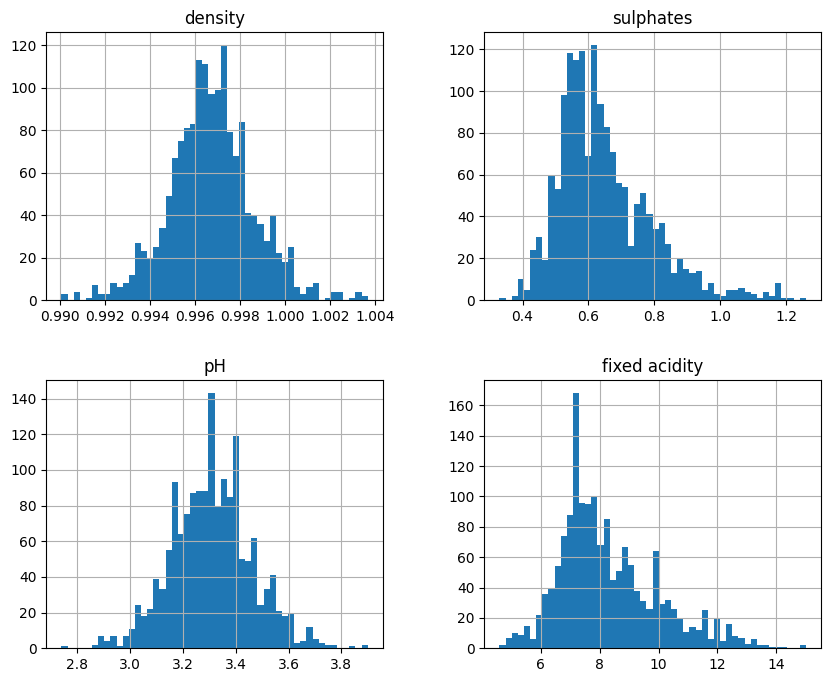

In [1089]:
df_normal = wine.get(["density","sulphates","pH","fixed acidity"])

K = 3
for column in df_normal.columns:
    serie = df_normal[column].to_numpy()
    Q1 = np.quantile(serie,0.25) # primer cuantil
    Q3 = np.quantile(serie,0.75) # tercer cuantil
    IQR = Q3 - Q1

    xl = Q1 - K*IQR # banda izquierda
    xu = Q3 + K*IQR # banda derecha

    median = np.median(serie)

    for i in range(0,len(serie)):
        if(serie[i]<xl or serie[i]>xu):
            print(f"Outlier en el campo {column} posicion {i} con valor {serie[i]}")
            serie[i] = median

df_normal.hist(bins=50,figsize=(10,8))




In [1090]:
wine[["density","sulphates","pH","fixed acidity"]] = df_normal

## Estudio de correlacion
Antes de proceder a la separacion de entrenamiento y test, necesitamos comprobar cuales son los campos que se relacionan peor o mejor con el objetivo y entre ellos

<Axes: >

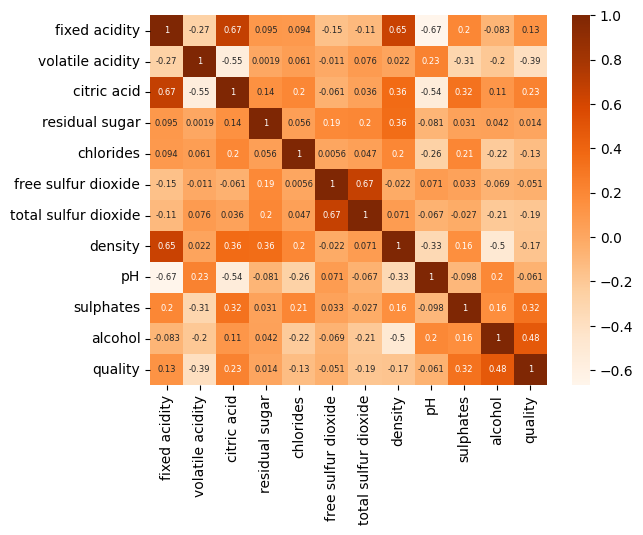

In [1091]:
sb.heatmap(wine.corr(method="pearson"),annot=True,annot_kws={"size":6},cmap=HMAP_COLOR)

Sobre el objetivo observamos que pH, free sulfur dioxide y residual sugar no se relacionan con el objetivo quality por lo que serán borrados

No hay campos que se relacionen mutuamente con una cantidad alta por lo que los campos a eliminar osn los mencionados

In [1092]:
wine = wine.drop(columns=["pH","free sulfur dioxide","residual sugar"])

## Transformacion a distribucion normal

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

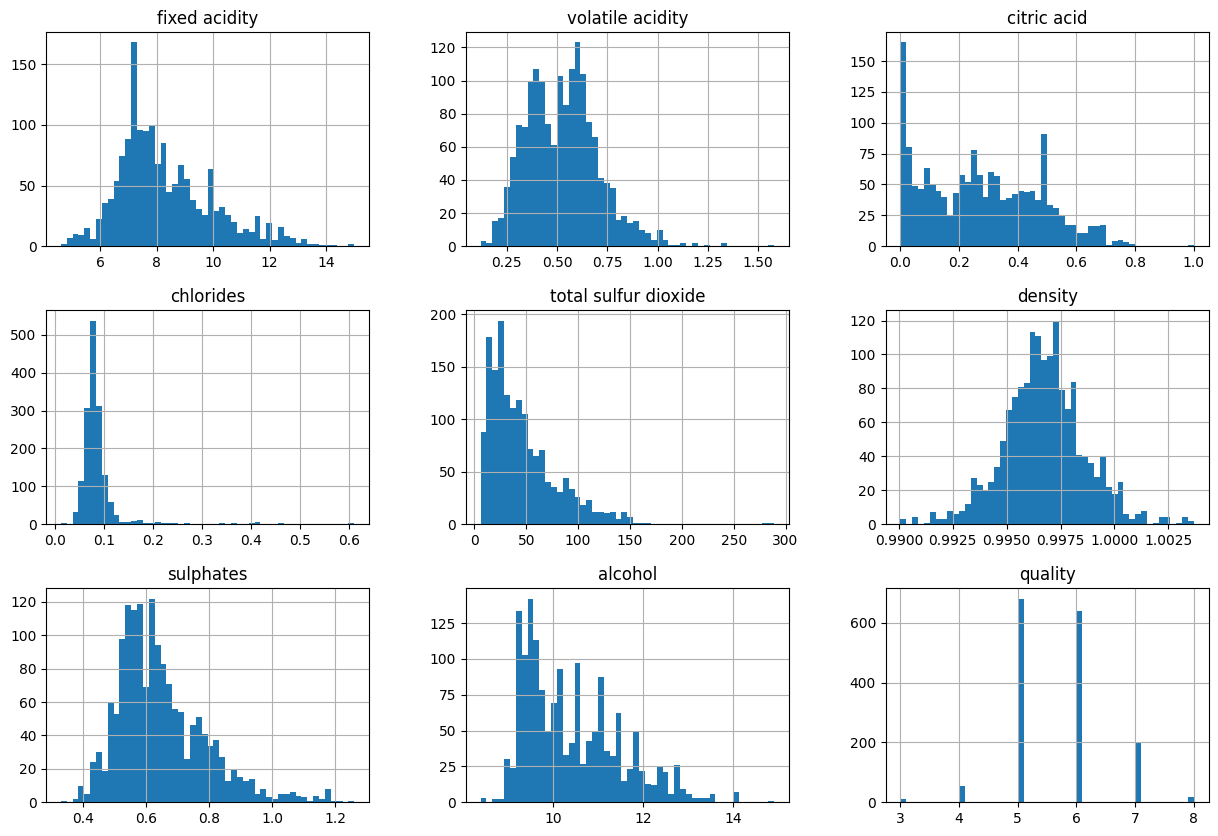

In [1093]:
wine.hist(bins=50,figsize=(15,10))

### Campos por transformacion por logaritmo
- total sulfur dioxide
- alcohol (arreglamos parte)
### Campos por transformacion por raiz cuadrada
- chlorides
### Sesgando la distribución y operando independientemente
- citric acid
- volatile acidity

In [1094]:
# transformacion por logaritmo
wine["total sulfur dioxide"] = np.log(wine["total sulfur dioxide"]+1) # se suma 1 para evitar logaritmo de 0
wine["alcohol"] = np.log10(wine["alcohol"]+1)

In [1095]:
# transformacion por raiz cuadrada
wine["chlorides"] = np.sqrt(wine["chlorides"])
wine[["citric acid"]] = np.sqrt(wine[["citric acid"]])


In [1096]:
# transformación sesgando la distribución y realizando un logaritmo sobre la parte deseada
citric_acid = wine["citric acid"].to_list()
citric_acid.sort()
citric_acid_q1 = []

for i,value in enumerate(citric_acid):
    if(value<0.2):
        citric_acid_q1.append(value)
        citric_acid.pop(i)

citric_acid_q1 = np.log1p(citric_acid_q1)

for i in citric_acid_q1:
    citric_acid.append(i)

wine["citric acid"] = citric_acid

In [1097]:
# transformacion aumentando la mediana detectando outliers, sesgando la distribucion y realizando un logaritmo


wine["volatile acidity"] = fix_outliers(wine["volatile acidity"].to_numpy(),"volatile acidity",strategy="median",k_value=3)
volatile_acidity = wine["volatile acidity"].to_list()
volatile_acidity.sort()
volatile_acidity_q1 = []

for i,value in enumerate(volatile_acidity):
    if(value<0.):
        volatile_acidity_q1.append(value)
        volatile_acidity.pop(i)

volatile_acidity = np.log1p(volatile_acidity)

for i in volatile_acidity_q1:
    volatile_acidity.append(i)

wine["volatile acidity"] = volatile_acidity

Outlier en el campo volatile acidity posicion 1299 con valor 1.58


### Resultado de la transformacion

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

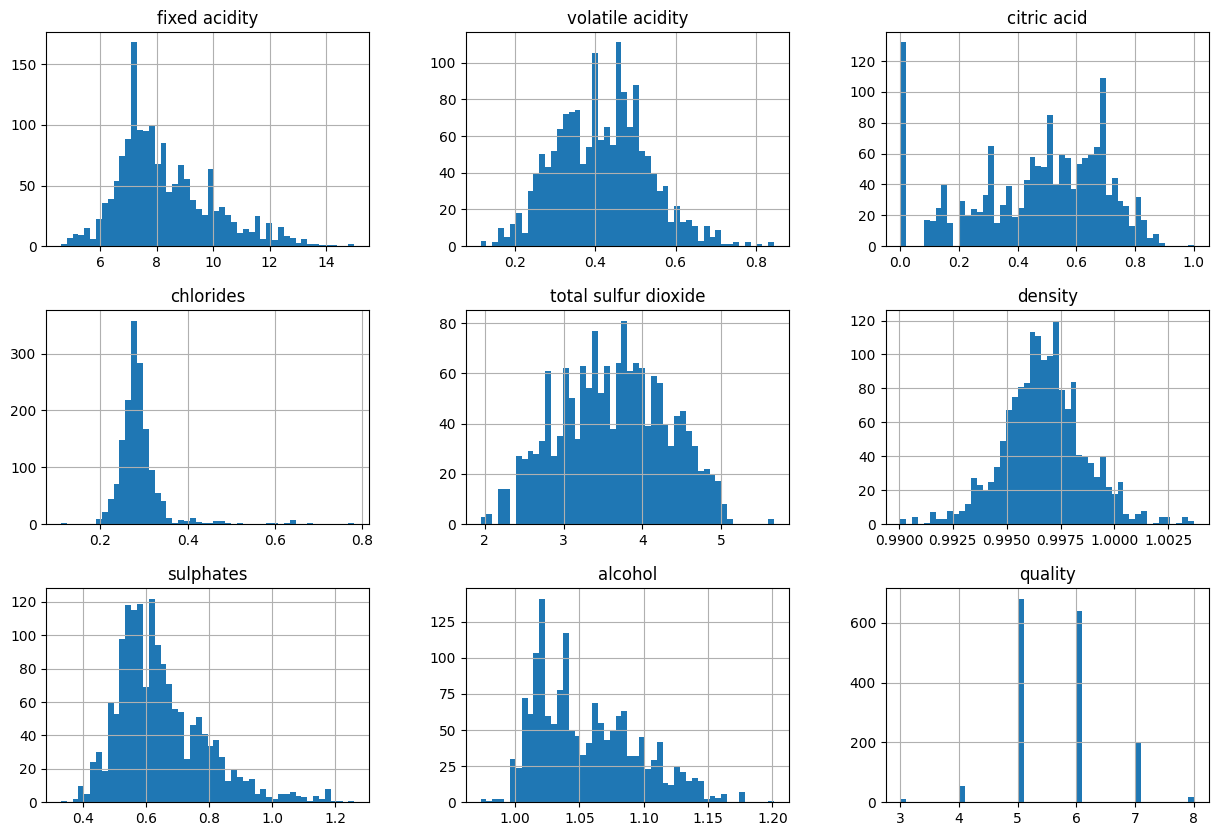

In [1098]:
wine.hist(bins=50,figsize=(15,10))

## Separación de datos
En este apartado se separará el dataset en entrenamiento y test, el porcentaje se medirá según el tamaño del dataset

In [1099]:
len(wine)

1599

Los datos se separarán en 70% entrenamiento y 30% test

In [1100]:
train,test = train_test_split(wine,test_size=0.3,train_size=0.7,random_state=SEED)
print(f"Conjunto de entrenamiento - {len(train)}\nConjunto de test - {len(test)}")

Conjunto de entrenamiento - 1119
Conjunto de test - 480


## Balanceo de las clases
El campo quality presenta un desbalanceo importante, es por ello que usaremos SMOTE, es una clase que genera datos sintéticos para igualar los valores de una clase en específico, en este caso de quality

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

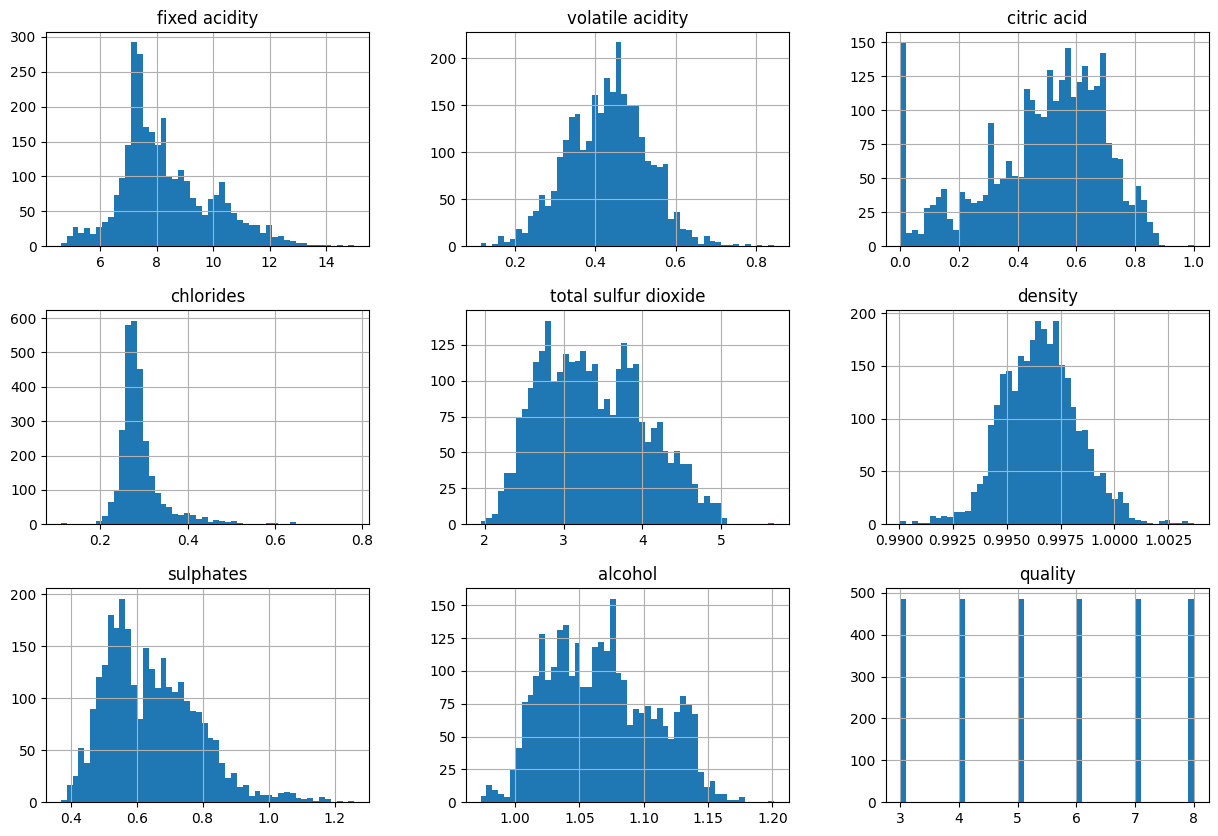

In [1101]:
smote = SMOTE(random_state=SEED)

train,quality = smote.fit_resample(train.drop(columns=["quality"]),train["quality"])
train["quality"] = quality
train.hist(bins=50,figsize=(15,10))

## Usamos OrdinalEncoder sobre quality para regresión con KNN

In [1102]:
# creamos un conjunto para knn-regresor
train = train
train.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,8.6,0.444686,0.600000,0.252982,4.356709,0.99604,0.87,1.079181,7
1,12.5,0.322083,0.360555,0.266458,2.772589,0.99880,0.87,1.049218,5
2,7.2,0.444686,0.583095,0.289828,4.369448,0.99640,0.71,1.079181,5
3,6.4,0.336472,0.412311,0.212132,3.891820,0.99490,0.49,1.093422,6
4,7.5,0.500775,0.700000,0.277489,4.110874,0.99630,0.59,1.033424,5


## Visualizacion general
Antes de elegir el escalador debemos de visualizar nuevamente los datos para determinar si utilizamos MinMaxScaler o StandardScaler

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

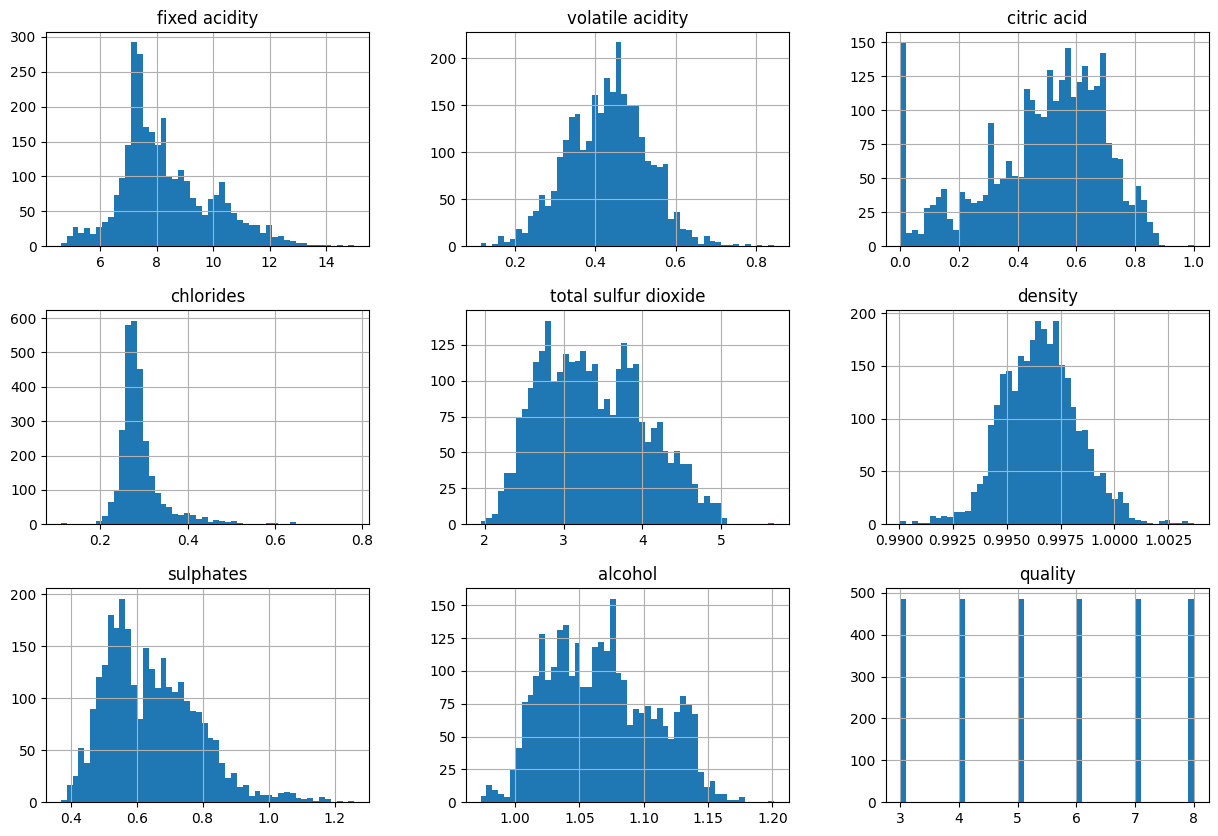

In [1103]:
train.hist(bins=50,figsize=(15,10))

La mayoría de las colas las hemos eliminado, pero las distribuciones no son del todo normales, además de que existen varios outliers por las distribuciones, por lo que el mejor escalador para este caso es StadardScaler

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

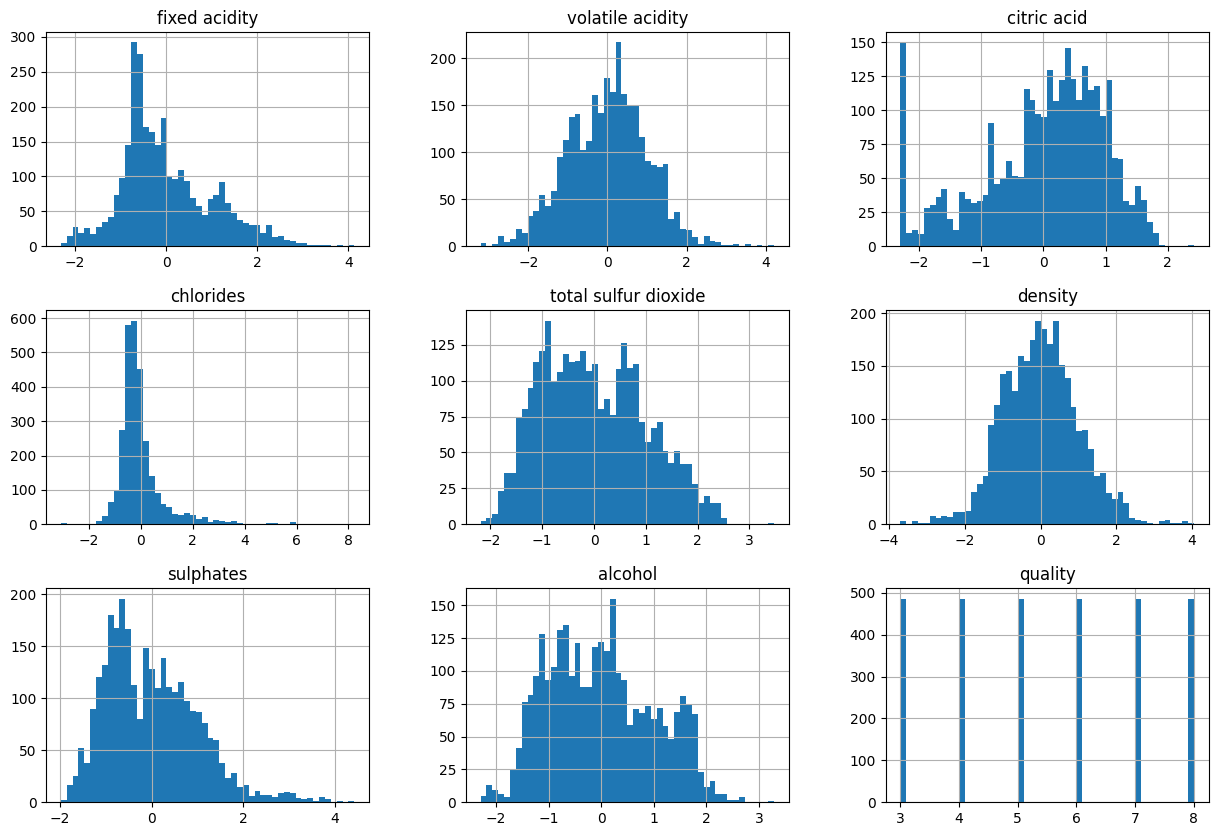

In [1104]:
ss_scaler = StandardScaler()
data_scale = train.drop(columns=["quality"])
quality = train["quality"]
ss_scaler.fit(data_scale)
train_scale = ss_scaler.transform(data_scale)

train = pd.DataFrame(data=train_scale,columns=data_scale.columns)
train["quality"] = quality

train.hist(bins=50,figsize=(15,10))

Guardamos el scaler para escalar mas tarde los datos de test utilizando solo transform

## Validación cruzada con KNN

In [1105]:
len(train)

2916

Valor maximo  uniform : 0.8532157910582568 (1)
Valor maximo  distance : 0.8532157910582568 (1)


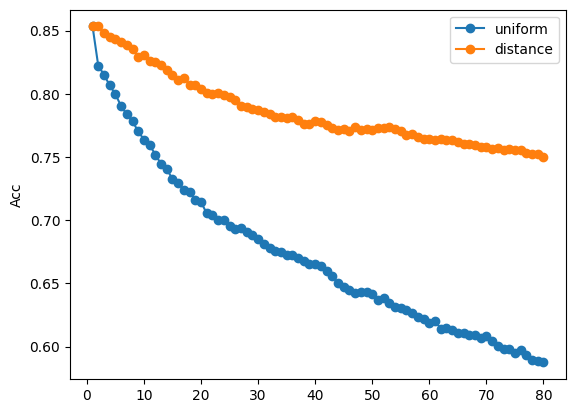

In [1106]:
# la longitud del conjunto de datos de entrenamiento es 160 por lo que se partira en 4 partes
SPLITS = 8
# como la longitud del conjunto de datos de entreno es 160 40 vecinos se ajusta muy bien como maximo
MAX_NEIGHBORS = 81
cross_validation = KFold(n_splits=SPLITS,shuffle=True,random_state=SEED)
hiperparam = {}
# iterado de los metodos de peso para comprobar cual se ajusta mejor
for i,weights in enumerate(["uniform","distance"]):
    scores = []
    # iterado de numero de vecinos para saber cual es el numero que mejor se ajusta
    for neighbor in range(1,MAX_NEIGHBORS):
        accuracy = []
        knn = KNeighborsClassifier(neighbor,weights=weights)
        # prueba del modelo del minimo de vecinos al maximo de vecinos
        for train_fold,test_fold in cross_validation.split(train):
            
            # seleccion aleatoria de datos de entrenamiento mediante indices
            r_train = train.iloc[train_fold]
            r_test = train.iloc[test_fold]

            # entrenamiento del modelo
            knn.fit(r_train.drop(columns=["quality"]),r_train["quality"])

            # prediccion del modelo usando los datos de entrenamiento 
            evaluation = knn.predict(r_test.drop(columns=["quality"]))

            accuracy.append(accuracy_score(r_test["quality"],evaluation))

        scores.append(np.mean(accuracy))
    
    # pintado de los puntos de los pesos que mejor encajan en el algoritmo
    plt.plot(range(1, len(scores)+1), scores,
             marker='o', label=weights)
    print ('Valor maximo  ' +  weights + " : " +  str(max(scores)) + " (" + str(np.argmax(scores) + 1) + ")")
    # guardamos el valor máximo del peso para evaluarlo más adelante
    hiperparam[weights] = np.argmax(scores)+1
    plt.ylabel('Acc')

plt.legend()
plt.show()


La validación cruzada nos dice que los mejores hiperparámetros para nuestro conjunto sería 1 vecino en uniform o en distancia, en este caso usaremos 2 vecinos con distance como peso

## Entrenamiento del modelo

In [1107]:
knn = KNeighborsClassifier(n_neighbors=2,weights="distance")

knn.fit(train.drop(columns=["quality"]),train["quality"])

KNeighborsClassifier(n_neighbors=2, weights='distance')

## Evaluacion del modelo
Usaremos el escalador con el que escalamos los datos de entrenamiento pero sin usar fit, sobre los datos de test

In [1108]:
test_scale = ss_scaler.transform(test.drop(columns=["quality"]))
columns = test.drop(columns=["quality"]).columns
quality = test["quality"]
test = pd.DataFrame(data=test_scale,columns=columns)
test.insert(1,"quality",quality.to_numpy())

In [1109]:
evaluation = knn.predict(test.drop(columns=["quality"]))

print(f"Precision del modelo {accuracy_score(test["quality"],evaluation)*100}%")
print(f"INFORME DE CLASIFICACIÓN:\n{classification_report(test["quality"],evaluation)}")

Precision del modelo 60.0%
INFORME DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.12      0.24      0.16        17
           5       0.75      0.71      0.73       195
           6       0.63      0.57      0.60       200
           7       0.47      0.49      0.48        61
           8       0.07      0.17      0.10         6

    accuracy                           0.60       480
   macro avg       0.34      0.36      0.34       480
weighted avg       0.63      0.60      0.61       480



## Matriz de confusión

<Axes: >

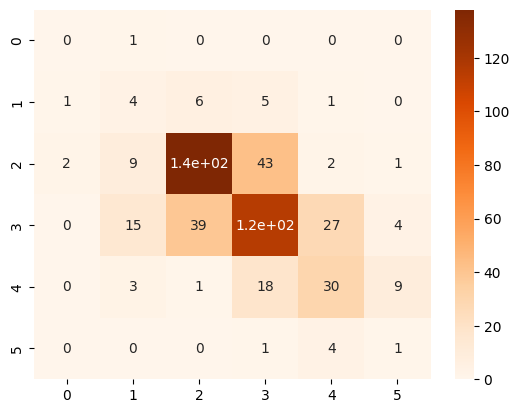

In [1110]:
sb.heatmap(confusion_matrix(test["quality"],evaluation),annot=True,cmap=HMAP_COLOR)

## Entrenamiento para KNNRegressor
Sin tocar los campos de test cogemos el entrenamiento ya procesado y le pasamos un OrdinalEncoder a quality para establecer un orden

In [1111]:
ord_encoder = OrdinalEncoder()
quality = train["quality"].to_numpy()
quality = quality[:,np.newaxis]
ord_encoder.fit(quality)
quality = ord_encoder.transform(quality)
train["quality"] = quality
train.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,0.168278,0.149265,0.533601,-0.677219,1.479564,-0.303925,1.616219,0.299948,4.0
1,2.584060,-1.091737,-0.596367,-0.450192,-0.932482,1.265925,1.616219,-0.432300,2.0
2,-0.698925,0.149265,0.453826,-0.056498,1.498961,-0.099162,0.464145,0.299948,2.0
3,-1.194470,-0.946092,-0.352127,-1.365408,0.771705,-0.952341,-1.119956,0.647959,3.0
4,-0.513096,0.717013,1.005513,-0.264365,1.105245,-0.156040,-0.399910,-0.818284,2.0


Realizamos una validacion cruzada con KNNRegressor

Valor maximo  uniform : 0.8532157910582568 (1)
Valor maximo  distance : 0.8532157910582568 (1)


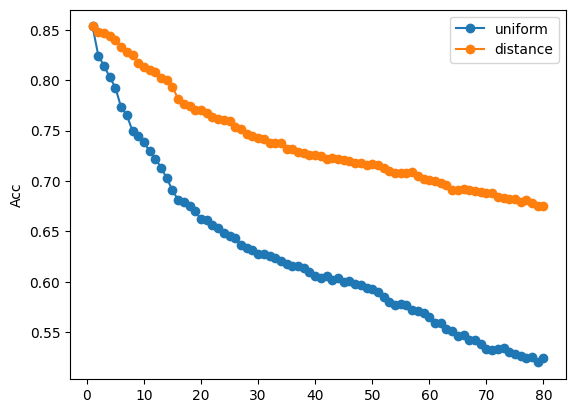

In [1112]:
# la longitud del conjunto de datos de entrenamiento es 160 por lo que se partira en 4 partes
SPLITS = 8
# como la longitud del conjunto de datos de entreno es 160 40 vecinos se ajusta muy bien como maximo
MAX_NEIGHBORS = 81
cross_validation = KFold(n_splits=SPLITS,shuffle=True,random_state=SEED)
hiperparam = {}
# iterado de los metodos de peso para comprobar cual se ajusta mejor
for i,weights in enumerate(["uniform","distance"]):
    scores = []
    # iterado de numero de vecinos para saber cual es el numero que mejor se ajusta
    for neighbor in range(1,MAX_NEIGHBORS):
        accuracy = []
        knn = KNeighborsRegressor(neighbor,weights=weights)
        # prueba del modelo del minimo de vecinos al maximo de vecinos
        for train_fold,test_fold in cross_validation.split(train):
            
            # seleccion aleatoria de datos de entrenamiento mediante indices
            r_train = train.iloc[train_fold]
            r_test = train.iloc[test_fold]

            # entrenamiento del modelo
            knn.fit(r_train.drop(columns=["quality"]),r_train["quality"])

            # prediccion del modelo usando los datos de entrenamiento 
            evaluation = knn.predict(r_test.drop(columns=["quality"]))

            evaluation = np.round(evaluation)

            accuracy.append(accuracy_score(r_test["quality"],evaluation))

        scores.append(np.mean(accuracy))
    
    # pintado de los puntos de los pesos que mejor encajan en el algoritmo
    plt.plot(range(1, len(scores)+1), scores,
             marker='o', label=weights)
    print ('Valor maximo  ' +  weights + " : " +  str(max(scores)) + " (" + str(np.argmax(scores) + 1) + ")")
    # guardamos el valor máximo del peso para evaluarlo más adelante
    hiperparam[weights] = np.argmax(scores)+1
    plt.ylabel('Acc')

plt.legend()
plt.show()

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1,weights="distance")

knn.fit(train.drop(columns=["quality"]),train["quality"])

KNeighborsRegressor(n_neighbors=1, weights='distance')

In [1114]:
quality = test["quality"].to_numpy()
quality = quality[:,np.newaxis]
quality = ord_encoder.transform(quality)
test["quality"] = quality
evaluation = knn.predict(test.drop(columns=["quality"]))

evaluation = np.round(evaluation)

print(f"Precision del modelo - {accuracy_score(test["quality"],evaluation)*100}%")
print(f"INFORME DE CLASIFICACION\n{classification_report(test["quality"],evaluation)}")

Precision del modelo - 60.0%
INFORME DE CLASIFICACION
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.12      0.24      0.16        17
         2.0       0.75      0.71      0.73       195
         3.0       0.63      0.57      0.60       200
         4.0       0.47      0.49      0.48        61
         5.0       0.07      0.17      0.10         6

    accuracy                           0.60       480
   macro avg       0.34      0.36      0.34       480
weighted avg       0.63      0.60      0.61       480

